# 21기 KNN 정규세션 과제

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

---

## 0. 데이터 불러오기

In [11]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/TOBIGS/5주차/blackfriday.csv", index_col = 0)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


## 1. Preprocssing / EDA

In [3]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,4.998000e+03,4998.000000,4998.000000,4998.000000,3465.000000,1544.000000,4998.000000
mean,1.003015e+06,8.036815,0.421369,5.320128,9.773737,12.766839,9234.655462
std,1.709910e+03,6.442697,0.493828,3.912281,5.101867,4.023591,4999.225081
min,1.000003e+06,0.000000,0.000000,1.000000,2.000000,3.000000,13.000000
25%,1.001560e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5497.750000
50%,1.003040e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8049.000000
75%,1.004417e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12039.000000
max,1.006037e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23913.000000


In [6]:
df.shape

(4998, 12)

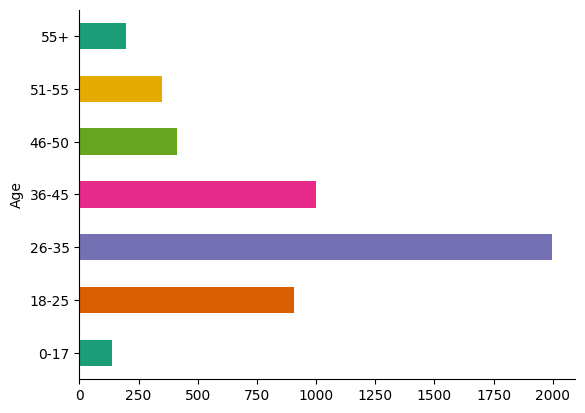

In [16]:
# @title Age

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Age').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
df.isnull().sum()

User_ID                          0
Product_ID                       0
Gender                           0
Age                              0
Occupation                       0
City_Category                    0
Stay_In_Current_City_Years       0
Marital_Status                   0
Product_Category_1               0
Product_Category_2            1533
Product_Category_3            3454
Purchase                         0
dtype: int64

In [14]:
df.drop(['Product_Category_3'], axis=1, inplace=True)

In [15]:
df.nunique()

User_ID                       2656
Product_ID                    1797
Gender                           2
Age                              7
Occupation                      21
City_Category                    3
Stay_In_Current_City_Years       5
Marital_Status                   2
Product_Category_1              20
Product_Category_2              17
Purchase                      3736
dtype: int64

In [20]:
## 예측 모델 활용하여 감당할 수 있는 열인 'Product_Category_2  '의 결측치 채워보기

from sklearn.ensemble import RandomForestClassifier
# 'Product_Category_2' 열의 결측치를 채우기 위해 학습 데이터와 테스트 데이터를 분리합니다.
train = df[df['Product_Category_2'].notna()]
test = df[df['Product_Category_2'].isna()]

# 학습 데이터와 테스트 데이터를 결합합니다.
combined = pd.concat([train, test])

# 범주형 변수를 원-핫 인코딩합니다.
combined_encoded = pd.get_dummies(combined)

# 학습 데이터와 테스트 데이터를 다시 분리합니다.
train_encoded = combined_encoded[combined_encoded['Product_Category_2'].notna()]
test_encoded = combined_encoded[combined_encoded['Product_Category_2'].isna()]

# 타겟 변수와 피처를 분리합니다.
X_train = train_encoded.drop('Product_Category_2', axis=1)
y_train = train_encoded['Product_Category_2']
X_test = test_encoded.drop('Product_Category_2', axis=1)

# 랜덤 포레스트 회귀 모델을 학습합니다.
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# 결측치를 예측합니다.
predicted = model.predict(X_test)

# 예측한 값으로 결측치를 채웁니다.
df.loc[df['Product_Category_2'].isna(), 'Product_Category_2'] = predicted


In [21]:
df.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Purchase                      0
dtype: int64

## 2. KNN 구현 & 파라미터 튜닝

In [40]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [ ]:
df.drop(['User_ID','Product_ID'], axis=1, inplace=True)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df['Purchase'], test_size=0.2, random_state=42)

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
knn_model = KNeighborsRegressor(n_neighbors = 10, weights = "uniform")
knn_model.fit(X_train_scaled, y_train)

KNeighborsRegressor(n_neighbors=10)

In [37]:
y_pred = knn_model.predict(X_test_scaled)

## 3. Evaluation

In [43]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_pred, y_test, squared = False)

4449.266570974367